# Life Pattern Report

The task is to generate a life pattern report for a user, which includes several useful information ranging from simple statistics to recommendations to improve the user’s life.

If you are running this on Google Colab, then since the storage isn't persistent, you will have to redownload the data whenever we start a new runtime.

I went ahead and hosted it all on GitHub, you can view it [here](https://github.com/tsainez/lifelogging), and clone it via `git clone https://github.com/tsainez/lifelogging.git`.

## Data analysis

All data used in this project is stored in the `csv` directory.

```
┌── preprocessing_visualization.ipynb
├── classification.ipynb
├── life_pattern_report.ipynb
└── csv
    ├── device_uplink.csv
    ├── user_information.csv
    └── user_action_annotation
        ├── 230.csv
        ├── ...
        └── 676.csv
```

I got rid of some of the user data because it was invalid or was irreparably corrupted.
- I chose not to use `499b.csv` because I wasn't sure what the data was or if I should just append it or not, and `499.csv` already seemed to have a good amount of data anyway.
- `507.csv` and `520.csv` seemed to contain the old `device_uplink`
  - While `507b.csv` did contain the data I was looking for, many of it's `start` and `end` values completley corrupted, showing only "`##########`"
    - Same for `536b.csv` and `634.csv`
- `530b.csv`, `545.csv`, `656.csv`, `669.csv`, `676.csv`, `512b.csv`, `635.csv`, and `655b.csv` are omitted for having too few entries in the data. The criteria for this was that the files had less than 100 entries.
  - The reasoning is that it might skew our models. For example, file `676.csv` only had 5 rows of data labeled. Also, some of these files did not even have enough rows to account for even one day, so the data would be useless anyway. 
- `230.csv` and `230b.csv` contain identical information; same for `514.csv` and `514b.csv`; and for `574.csv` and `574b.csv`. In order to not overrepresent this data, I chose to remove the `b` counterparts to each dataset. 
- `478.csv`, `506.csv`, `514.csv`, and `524.csv` were removed because they did not have a depression score in the old user information dataset. The depression score was needed in order to make a health score, so I could not use these files.

In [1]:
import pandas as pd
import os 
import re

path = "csv/user_action_annotation/"
files = [f for f in os.listdir(path) if f.endswith('.csv')]

data = pd.DataFrame()
duplicates = pd.DataFrame(columns = ['num'])

for file in files:
    id = re.findall(r'\d+', file)
    temp = pd.read_csv(path + file)
    temp['id'] = id[0]
    duplicates.loc[id[0]] = temp.duplicated().size
    data = pd.concat([data, temp])

# Normalize all columns to ensure data integrity. 
data['start'] = pd.to_datetime(data['start'])
data['end'] = pd.to_datetime(data['end'])
data['labelName'] = data['labelName'].str.upper()
data['labelName'] = data['labelName'].astype('category')
data['id'] = pd.to_numeric(data['id'])

data

,start,end,labelName,id
0,2020-11-01 11:00:00,2020-11-01 11:30:00,COOK,551
1,2020-11-01 11:30:00,2020-11-01 12:00:00,EAT,551
2,2020-11-01 13:00:00,2020-11-01 13:30:00,COOK,551
3,2020-11-01 13:30:00,2020-11-01 14:00:00,COOK,551
4,2020-11-01 14:00:00,2020-11-01 14:30:00,EAT,551
...,...,...,...,...
4276,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574
4277,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574
4278,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574
4279,2021-03-11 16:00:00,2021-03-11 16:30:00,SLEEP,574


There were a huge amount of duplicates in the data. Here's a bar graph that shows how many duplicates there were per user. 

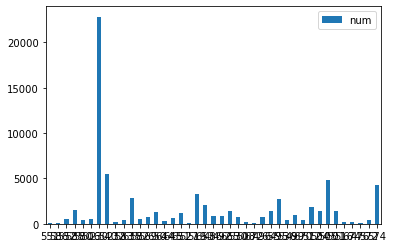

In [2]:
import matplotlib.pyplot as plt
# %matplotlib inline

duplicates.plot.bar(y='num', rot=0)
plt.show()

As you can see, most of the files had errors, with one having more than 20,000 duplicated entries. It's not entirely clear how most of these files ended up with so many duplicated rows— nonetheless, they are removed from the total dataset.

In [3]:
data = data.drop_duplicates()
data

,start,end,labelName,id
0,2020-11-01 11:00:00,2020-11-01 11:30:00,COOK,551
1,2020-11-01 11:30:00,2020-11-01 12:00:00,EAT,551
2,2020-11-01 13:00:00,2020-11-01 13:30:00,COOK,551
3,2020-11-01 13:30:00,2020-11-01 14:00:00,COOK,551
4,2020-11-01 14:00:00,2020-11-01 14:30:00,EAT,551
...,...,...,...,...
4249,2021-03-11 14:00:00,2021-03-11 14:30:00,GO WALK,574
4259,2021-03-11 15:00:00,2021-03-11 15:30:00,GO WALK,574
4270,2021-03-11 15:00:00,2021-03-11 15:30:00,SLEEP,574
4276,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574


We went from 105927 entries to just 72403 entries! That's a 31.6482% decrease.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72403 entries, 0 to 4279
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start      72403 non-null  datetime64[ns]
 1   end        72403 non-null  datetime64[ns]
 2   labelName  72403 non-null  category      
 3   id         72403 non-null  int64         
dtypes: category(1), datetime64[ns](2), int64(1)
memory usage: 2.3 MB


In [5]:
pd.unique(data['labelName'])

['COOK', 'EAT', 'GO WALK', 'GO TO BATHROOM', 'WASH DISHES', ..., 'WORK OUT', 'DRINK', 'WAKE UP', 'SLEEP', 'WATCH TV']
Length: 14
Categories (14, object): ['COOK', 'EAT', 'GO WALK', 'GO TO BATHROOM', ..., 'DRINK', 'WAKE UP', 'SLEEP', 'WATCH TV']

In [6]:
data['labelName'].value_counts()

SLEEP             17567
EAT               14107
GO TO BATHROOM    11466
COOK               6365
NONE               4920
WAKE UP            4796
TAKE MEDICINE      4158
WASH DISHES        1946
GO WALK            1940
TAKE SHOWER        1749
DRINK              1716
WORK OUT            868
CLEAN               543
WATCH TV            262
Name: labelName, dtype: int64

As you can see, the most commonly reported labels were "sleep." The next was "eat" and "go to bathroom," but I did not feel like these would be good encapsulators of a health score. I have seen some research on over-eating and under-eating in relation to depression, however I wasn't sure how to identify or measure whether or not the user was suffering from any eating disorders. 

I know from domain knowledge, also, that regular sleep patterns are healthy and desirable. On the other hand, unhealthy or irregular sleep patterns can be indications of distress or even depression. Although I know that it would be possible (and more accurate for modeling purposes) to measure consecutive sleep hours, I decided based on my time limits to measure a statistical average of the user's sleep. Different people need different amounts of sleep, so this method is tailored to each user. Plus, I also know that from research eldery people typically tend to sleep less— or as some researchers have put it: "need less sleep." 

The next best option would be to take into account how much medicine they take on average. If a user regularly takes medicine three times a day, then it's best that they continue to do so. Of course, taking no medicine is also sometimes an indicator of good health. The issue with this is that it's all on a highly individualzied basis. Some users may not need to take any medication and are very healthy— some can only be considered healthy by medical professionals in the case that they do take their medicine. 

## Health score generation
Next, the `labelName` column is going to be split into it's 14 unique categories— a column for each. These new columns will record how many hours a user has logged for a particular label. For example, if a user has `206.0` in `SLEEP` for the month `Feb2020`, then that means the user slept 206 hours in the month of February, 2019. This is converted over from the 30 minute intervals that were logged originally for ease of manipulation.  

In [7]:
# https://stackoverflow.com/questions/72456623/sum-of-individual-labels-over-a-month-of-granular-data
df = (pd.crosstab([data['id'], data['end'].dt.to_period('m')], data['labelName']).mul(0.5)
        .rename(columns=str)
        .rename_axis(columns=None, index=['id','month'])
        .reset_index()
        .assign(month=lambda x:x['month'].dt.strftime('%b%Y')))

df

,id,month,CLEAN,COOK,DRINK,EAT,GO TO BATHROOM,GO WALK,NONE,SLEEP,TAKE MEDICINE,TAKE SHOWER,WAKE UP,WASH DISHES,WATCH TV,WORK OUT
0,230,Dec2019,0.5,0.5,0.5,0.0,0.0,0.5,0.0,23.5,0.5,0.0,0.0,0.5,0.0,0.0
1,230,Feb2020,0.5,14.5,0.5,1.5,0.0,16.0,0.0,206.0,22.5,51.5,32.5,0.0,0.0,0.0
2,230,Mar2020,0.0,9.0,0.5,25.5,0.0,14.0,0.0,362.5,16.5,85.0,79.0,0.0,0.0,0.0
3,230,Apr2020,0.0,0.0,0.0,19.5,0.0,0.0,0.0,378.5,0.0,97.5,40.0,0.0,0.0,0.0
4,230,May2020,0.0,0.0,0.0,17.5,0.0,0.0,0.0,428.5,0.0,28.0,39.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,672,Mar2021,0.0,3.0,1.5,7.0,14.0,0.0,0.0,0.5,4.0,0.5,3.5,8.0,0.0,0.0
262,674,Sep2020,2.5,1.5,0.0,8.5,6.5,0.0,0.0,2.0,1.0,0.0,1.0,0.5,0.0,0.0
263,674,Oct2020,5.0,12.0,0.5,25.0,4.5,0.0,0.0,1.5,1.0,0.0,3.5,0.0,0.0,0.0
264,674,Nov2020,1.0,2.5,0.0,7.0,1.0,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0,0.0


Next, we're gonna generate the health score from this table.

The formula is defined below. It takes a row of data— a month's worth— and compares each label to the user's alltime averages. Then we divided it by 15— the number of labels— so that we can get a baseline (mean) score of 1, which makes it easy to see if a user did well or not. This formula seeks to ensure that a user is following a stable, established routine for that month. Deviation from their routine (represented by the alltime averages) is punished in the health score. This method clearly has a few flaws— mainly, it's all based on statistical averages and it simplifies things greatly.

In [8]:
def health_score(row, averages):
    score = 0

    averages = averages.drop(averages.index[0])
    row = row.drop(row.index[[0, 1]])
    
    for i in range(len(row)): 
        if averages[i] != 0:
            score += row[i]/averages[i]
            
    return score / len(row)

Here, I define a new truncated dataframe that serves to keep only the most important information.

In [9]:
df['health_score'] = df.apply(lambda row: health_score(row, df.mean(axis=0)), axis=1)

# Attach the depression score to the dataframe.
user_information = pd.read_csv('csv/user_information.csv')
df = pd.merge(df, user_information, left_on='id', right_on='user_id', how='inner')

# We don't need these additional columns...
df.drop(['user_id', 'birth year', 'age', 'sex', 'etc', 'depression_class'], inplace = True, axis = 1)

df

,id,month,CLEAN,COOK,DRINK,EAT,GO TO BATHROOM,GO WALK,NONE,SLEEP,TAKE MEDICINE,TAKE SHOWER,WAKE UP,WASH DISHES,WATCH TV,WORK OUT,health_score,depression_score
0,230,Dec2019,0.5,0.5,0.5,0.0,0.0,0.5,0.0,23.5,0.5,0.0,0.0,0.5,0.0,0.0,0.124009,0.125
1,230,Feb2020,0.5,14.5,0.5,1.5,0.0,16.0,0.0,206.0,22.5,51.5,32.5,0.0,0.0,0.0,2.477740,0.125
2,230,Mar2020,0.0,9.0,0.5,25.5,0.0,14.0,0.0,362.5,16.5,85.0,79.0,0.0,0.0,0.0,3.815362,0.125
3,230,Apr2020,0.0,0.0,0.0,19.5,0.0,0.0,0.0,378.5,0.0,97.5,40.0,0.0,0.0,0.0,3.306562,0.125
4,230,May2020,0.0,0.0,0.0,17.5,0.0,0.0,0.0,428.5,0.0,28.0,39.5,0.0,0.0,0.0,1.895365,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,672,Mar2021,0.0,3.0,1.5,7.0,14.0,0.0,0.0,0.5,4.0,0.5,3.5,8.0,0.0,0.0,0.348831,0.625
251,674,Sep2020,2.5,1.5,0.0,8.5,6.5,0.0,0.0,2.0,1.0,0.0,1.0,0.5,0.0,0.0,0.259500,0.000
252,674,Oct2020,5.0,12.0,0.5,25.0,4.5,0.0,0.0,1.5,1.0,0.0,3.5,0.0,0.0,0.0,0.554993,0.000
253,674,Nov2020,1.0,2.5,0.0,7.0,1.0,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.120651,0.000


The old dataframe containing every label is kept in order to compare whether or not using the health score or all 14 original categories would provide a model that's more accurate. 

In [10]:
# We no longer need these columns, so we define a new truncated dataframe.
health_score_df = df.drop(df.iloc[:, 2:16], axis = 1)

health_score_df

,id,month,health_score,depression_score
0,230,Dec2019,0.124009,0.125
1,230,Feb2020,2.477740,0.125
2,230,Mar2020,3.815362,0.125
3,230,Apr2020,3.306562,0.125
4,230,May2020,1.895365,0.125
...,...,...,...,...
250,672,Mar2021,0.348831,0.625
251,674,Sep2020,0.259500,0.000
252,674,Oct2020,0.554993,0.000
253,674,Nov2020,0.120651,0.000


In [11]:
health_score_df.describe()

,id,health_score,depression_score
count,255.000000,255.000000,255.000000
mean,525.823529,0.924732,0.307843
std,120.748308,1.093597,0.292773
min,230.000000,0.001657,0.000000
25%,499.000000,0.170900,0.000000
50%,536.000000,0.546580,0.250000
75%,585.000000,1.186830,0.500000
max,674.000000,7.182213,1.000000


Let's look at a sample user: 230. This user has reported a depression level of "normal" and also appear to have a mean healthscore above the standard!

In [12]:
sample = health_score_df.loc[df['id'] == 230]
sample.mean()

id                  230.000000
health_score          2.565523
depression_score      0.125000
dtype: float64

In [13]:
health_score_df = health_score_df.groupby(['id']).mean()

health_score_df.head()

,health_score,depression_score
id,,
230,2.565523,0.125
232,2.552161,0.000
476,0.070495,0.000
486,1.063202,0.500
492,0.633270,0.500


Notice that while `df`'s mean health score was 1, when it's grouped by user the mean health score decreases. This is likely explained by the fact that this dataset comes from mostly depressed individuals. So, when oriented in this manner the overall mean drops. More users are depressed in this dataset than they are happy. 

In [14]:
health_score_df.describe()

,health_score,depression_score
count,37.000000,37.000000
mean,0.772036,0.317568
std,0.730090,0.296968
min,0.050338,0.000000
25%,0.245307,0.000000
50%,0.502580,0.250000
75%,1.063202,0.500000
max,2.830069,1.000000


## Machine learning
In machine learning, models are usually categorized as either regressors or classifiers. The models I chose were all regressors, since I found working with only numerical data greatly simplified my workflow and meant that I could potentially finish on time.

Now, we will train a model based on `healthScore` to predict `depression_score`. These models are bound to be incredibly simplistic, but I was really strapped for time and couldn't find a better alternative. In other words, we predicting whether or not a user will be depressed based off of the their monthly average health score. A health score report can be generated for a user based off of one month's worth of data provided by the user and then applied to the model. 

In [15]:
x = health_score_df['health_score']
y = health_score_df['depression_score']

x = x.to_numpy()
y = y.to_numpy()

x = x.reshape(-1, 1)

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x, y)
print("Linear Regression: " + str(model.score(x, y)))

Linear Regression: 0.023437927166822248


Okay, so as I predicted this was terrible on my first try. Let's see what a linear regressor that is robust to outliers would report. I noticed that in my dataset there might have been a few outliers, and since the dataset is especially small perhaps this might make it perform better.

In [17]:
from sklearn.linear_model import HuberRegressor

model = HuberRegressor().fit(x, y)
print("Huber Regressor: " + str(model.score(x, y)))

Huber Regressor: 0.010105220917809077


In this case, it did even worse— indicating that it's not the outliers that are the problem here. Perhaps it is also because my dataset is incredibly small. So, instead of using the health score I have generated, I have instead decided to train a model on the original 14 categories. 

In [18]:
x = df.iloc[:, 2:16]
y = df['depression_score']

model = LinearRegression().fit(x, y)
print("Linear Regression: " + str(model.score(x, y)))

Linear Regression: 0.23491529916657639


This is significantly better, as you can see. Perhaps my simplification based off of statistical averages was the incorrect approach after all. In the next section, I am going to try a lot of different regression methods and see how they all perform. The list includes:

- [Bayesian ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)
- [Multi-layer Perceptron regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)
- [Epsilon-Support Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [Linear model fitted by minimizing a regularized empirical loss with SGD](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
    - SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).
- [Regression based on k-nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
- [A decision tree regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

My reasoning behind throwing so many different regression methods at this dataset is that I think examining the differences in their performance might yield noteworthy or insightful results. While I realize that this is not a realistic or sustainable method for huge datasets, I would still like to mention that a lot of computer science research papers seem to employ this method of trial and error.

In [19]:
# This dataset is somewhat small, as it contains only the monthly data.
# Still, splitting it into train and test is a good idea.
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Linear regressors
from sklearn.linear_model import BayesianRidge
model = BayesianRidge().fit(x, y)
print("Bayesian regression score: " + str(model.score(x_test, y_test)))

# Neural networks
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state=1, max_iter=500).fit(x, y)
print("MLP regressor score: " + str(model.score(x_test, y_test)))

# Support vector machines
from sklearn import svm
model = svm.SVR().fit(x, y)
print("Support vector machines: " + str(model.score(x_test, y_test)))

# Stochastic gradient descent
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
model.fit(x, y)
print("Stochastic gradient descent: " + str(model.score(x_test, y_test)))

# Nearest neighbors
from sklearn import neighbors

scores = []

print("\nK-nearest neighbors: ")
for k in range(2,14):
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(x, y)

    scores.append({
        'k': k,
        'score': model.score(x_test, y_test)
    })

    print('\t' + str(k) + "-nearest neighbors: " + str(model.score(x_test, y_test)))

# Decision trees
from sklearn import tree
model = tree.DecisionTreeRegressor()
model = model.fit(x, y)
print("\nDecision trees: " + str(model.score(x_test, y_test)))

Bayesian regression score: 0.18148899671649765
MLP regressor score: -29.142460920166037
Support vector machines: 0.14541165621003727
Stochastic gradient descent: 0.18239295547112477

K-nearest neighbors: 
	2-nearest neighbors: 0.21490940291727667
	3-nearest neighbors: 0.2122876674686094
	4-nearest neighbors: 0.24145447433503264
	5-nearest neighbors: 0.22434765053247885
	6-nearest neighbors: 0.2591809810618172
	7-nearest neighbors: 0.2477418969404751
	8-nearest neighbors: 0.24269458499470054
	9-nearest neighbors: 0.23845205760278365
	10-nearest neighbors: 0.25566547216474045
	11-nearest neighbors: 0.2806261270148619
	12-nearest neighbors: 0.26303910311411705
	13-nearest neighbors: 0.2581532297394844

Decision trees: 0.04330490082269234


<AxesSubplot:xlabel='k', ylabel='score'>

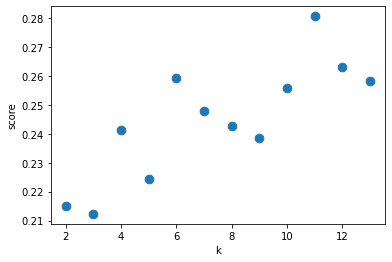

In [20]:
scores = pd.DataFrame(scores)
scores.plot.scatter(s=75, y='score', x='k')

As you can see above, the more neighbors we add to the K-nearest neighbors algorithm, the better the accuracy becomes. The decision tree were also completley inaccurate. Because I think this is a case of overfitting, I decided to try a Random Forest regression method in order to avoid decision tree overfitting and because I could iterate over max depth and examine the results there.

In [21]:
from sklearn.ensemble import RandomForestRegressor

scores = []

for i in range(2,14):
    model = RandomForestRegressor(max_depth=i, random_state=0)
    model.fit(x, y)

    scores.append({
        'max_depth': i,
        'score': model.score(x_test, y_test)
    })

    print("(depth " + str(i) + ") Random forest: " + str(model.score(x_test, y_test)))

(depth 2) Random forest: 0.3010067191678357
(depth 3) Random forest: 0.345557779125812
(depth 4) Random forest: 0.38401248818121136
(depth 5) Random forest: 0.43430820637030054
(depth 6) Random forest: 0.4446332850210216
(depth 7) Random forest: 0.45765355227861526
(depth 8) Random forest: 0.4616343351606619
(depth 9) Random forest: 0.4707539501228768
(depth 10) Random forest: 0.46831861151182086
(depth 11) Random forest: 0.4778991768919949
(depth 12) Random forest: 0.47845267477819486
(depth 13) Random forest: 0.4730744438805963


<AxesSubplot:xlabel='max_depth', ylabel='score'>

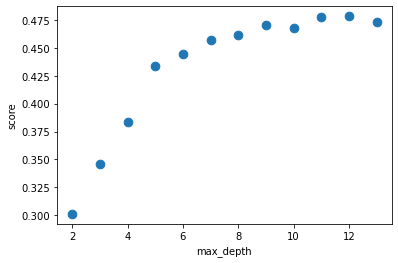

In [22]:
scores = pd.DataFrame(scores)
scores.plot.scatter(s=75, y='score', x='max_depth')

As you can see, as the `max_depth` of the random forest increases, it approaches better accuracy until it hits an inflection point. This is in line with my current understanding of how this model works. Seeing that it has the least propensity for overfitting and the best accuracy out of all the models I tried so far, I chose this as my final model, specifically with  `max_depth = 6` to avoid overfitting.

In [23]:
model = RandomForestRegressor(max_depth=6, random_state=0)
model.fit(x, y)

from dmba import regressionSummary
regressionSummary(y_test, model.predict(x_test))

no display found. Using non-interactive Agg backend

Regression statistics

               Mean Error (ME) : 0.0105
Root Mean Squared Error (RMSE) : 0.2182
     Mean Absolute Error (MAE) : 0.1607


Let's try some other linear regression models— mainly forward selection, backwards elimination and stepwise refinement. First I define some helper functions.

In [24]:
from dmba import AIC_score

# First, let's define some helper functions.
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(x[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
       return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(x[variables]), model)

### Forward selection
- Start with no predictors
- Add them one by one (add the one with largest contribution)
- Stop when the addition is not statistically significant

In [25]:
from dmba import forward_selection
    
best_model, best_variables = forward_selection(x.columns, train_model, score_model,verbose=True)

print("\nBest variables: " + str(best_variables))
regressionSummary(y_test, best_model.predict(x_test[best_variables]))

Variables: CLEAN, COOK, DRINK, EAT, GO TO BATHROOM, GO WALK, NONE, SLEEP, TAKE MEDICINE, TAKE SHOWER, WAKE UP, WASH DISHES, WATCH TV, WORK OUT
Start: score=67.29, constant
Step: score=56.34, add NONE
Step: score=46.08, add GO TO BATHROOM
Step: score=40.77, add SLEEP
Step: score=38.70, add CLEAN
Step: score=38.70, add None

Best variables: ['NONE', 'GO TO BATHROOM', 'SLEEP', 'CLEAN']

Regression statistics

               Mean Error (ME) : 0.0244
Root Mean Squared Error (RMSE) : 0.2590
     Mean Absolute Error (MAE) : 0.2101


### Backwards Elimination
- Start with all predictors
- Successively eliminate least useful predictors one by one
- Stop when all remaining predictors have statistically significant contribution

In [26]:
from dmba import backward_elimination
allVariables = x.columns

best_model, best_variables = backward_elimination(allVariables, train_model, score_model, verbose=True)

print("\nBest variables: " + str(best_variables))
regressionSummary(y_test, best_model.predict(x_test[best_variables]))

Variables: CLEAN, COOK, DRINK, EAT, GO TO BATHROOM, GO WALK, NONE, SLEEP, TAKE MEDICINE, TAKE SHOWER, WAKE UP, WASH DISHES, WATCH TV, WORK OUT
Start: score=53.41
Step: score=51.41, remove TAKE SHOWER
Step: score=49.41, remove WATCH TV
Step: score=47.41, remove TAKE MEDICINE
Step: score=45.48, remove WAKE UP
Step: score=43.73, remove EAT
Step: score=42.18, remove DRINK
Step: score=41.24, remove WORK OUT
Step: score=40.34, remove WASH DISHES
Step: score=39.30, remove COOK
Step: score=38.70, remove GO WALK
Step: score=38.70, remove None

Best variables: ['CLEAN', 'GO TO BATHROOM', 'NONE', 'SLEEP']

Regression statistics

               Mean Error (ME) : 0.0244
Root Mean Squared Error (RMSE) : 0.2590
     Mean Absolute Error (MAE) : 0.2101


Interestingly this is different from my findings in project 2, wherein each method returned the exact same variables. We can already see now that the selected best variables are different!

### Stepwise refinement
- Like forward selection	
- Except at each step, also consider dropping non-significant predictors

In [27]:
from dmba import stepwise_selection
best_model, best_variables = stepwise_selection(x.columns, train_model, score_model, verbose=True)

print("\nBest variables: " + str(best_variables))
regressionSummary(y_test, best_model.predict(x_test[best_variables]))

Variables: CLEAN, COOK, DRINK, EAT, GO TO BATHROOM, GO WALK, NONE, SLEEP, TAKE MEDICINE, TAKE SHOWER, WAKE UP, WASH DISHES, WATCH TV, WORK OUT
Start: score=67.29, constant
Step: score=56.34, add NONE
Step: score=46.08, add GO TO BATHROOM
Step: score=40.77, add SLEEP
Step: score=38.70, add CLEAN
Step: score=38.70, unchanged None

Best variables: ['NONE', 'GO TO BATHROOM', 'SLEEP', 'CLEAN']

Regression statistics

               Mean Error (ME) : 0.0244
Root Mean Squared Error (RMSE) : 0.2590
     Mean Absolute Error (MAE) : 0.2101


All of them gave me the same best variables: `['NONE', 'GO TO BATHROOM', 'SLEEP', 'CLEAN']`. So I will use these and try to test again with less variables, and see if it increases my model accuracy. 

In [28]:
x = df[['NONE', 'GO TO BATHROOM', 'SLEEP', 'CLEAN']]
y = df['depression_score']

x, x_test, y, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [29]:
# Linear regressors
from sklearn.linear_model import BayesianRidge
model = BayesianRidge().fit(x, y)
print("Bayesian regression score: " + str(model.score(x_test, y_test)))

# Neural networks
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state=1, max_iter=500).fit(x, y)
print("MLP regressor score: " + str(model.score(x_test, y_test)))

# Support vector machines
from sklearn import svm
model = svm.SVR().fit(x, y)
print("Support vector machines: " + str(model.score(x_test, y_test)))

# Stochastic gradient descent
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
model.fit(x, y)
print("Stochastic gradient descent: " + str(model.score(x_test, y_test)))

# Nearest neighbors
from sklearn import neighbors

scores = []

print("\nK-nearest neighbors: ")
for k in range(2,14):
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(x, y)

    scores.append({
        'k': k,
        'score': model.score(x_test, y_test)
    })

    print('\t' + str(k) + "-nearest neighbors: " + str(model.score(x_test, y_test)))

# Decision trees
from sklearn import tree
model = tree.DecisionTreeRegressor()
model = model.fit(x, y)
print("\nDecision trees: " + str(model.score(x_test, y_test)))

Bayesian regression score: 0.16967866919825914
MLP regressor score: -104.33060888885342
Support vector machines: 0.1930664155061329
Stochastic gradient descent: 0.20651204868223205

K-nearest neighbors: 
	2-nearest neighbors: 0.22295336395296028
	3-nearest neighbors: 0.2234896280220059
	4-nearest neighbors: 0.2532522838540353
	5-nearest neighbors: 0.24502599303487627
	6-nearest neighbors: 0.24511894547351054
	7-nearest neighbors: 0.22497803441772413
	8-nearest neighbors: 0.21219456606773335
	9-nearest neighbors: 0.20119163562020959
	10-nearest neighbors: 0.19807071114924546
	11-nearest neighbors: 0.20716238149007282
	12-nearest neighbors: 0.2171885252107204
	13-nearest neighbors: 0.22156034663751045

Decision trees: -0.10255892595770444


<AxesSubplot:xlabel='k', ylabel='score'>

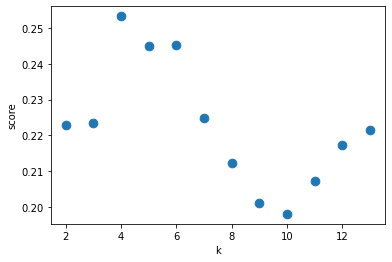

In [30]:
scores = pd.DataFrame(scores)
scores.plot.scatter(s=75, y='score', x='k')

In [31]:
scores = []

for i in range(2,14):
    model = RandomForestRegressor(max_depth=i, random_state=0)
    model.fit(x, y)

    scores.append({
        'max_depth': i,
        'score': model.score(x_test, y_test)
    })

    print("(depth " + str(i) + ") Random forest: " + str(model.score(x_test, y_test)))

(depth 2) Random forest: 0.30690193018299083
(depth 3) Random forest: 0.33521720731087956
(depth 4) Random forest: 0.34137087919341924
(depth 5) Random forest: 0.3484054075818014
(depth 6) Random forest: 0.3562394808417738
(depth 7) Random forest: 0.347238455418145
(depth 8) Random forest: 0.3409519617406013
(depth 9) Random forest: 0.32718864323742025
(depth 10) Random forest: 0.31114315298572115
(depth 11) Random forest: 0.30445231350821855
(depth 12) Random forest: 0.28659351501675934
(depth 13) Random forest: 0.27925387467490903


Here we can see the best random forest model outperforms the other models in regression accuracy. The best model can be found at `max_depth = 6`. Unfortunately, this model is still incredibly low accuracy.

<AxesSubplot:xlabel='max_depth', ylabel='score'>

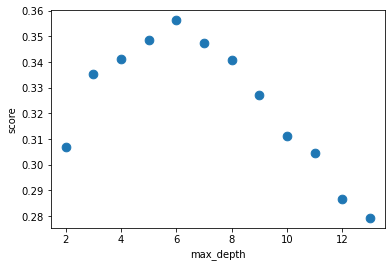

In [32]:
scores = pd.DataFrame(scores)
scores.plot.scatter(s=75, y='score', x='max_depth')

I'm not entirely sure why the accuracy is so low. I've tried almost every method I could and the only conclusion I can come up with is that perhaps the data might be difficult for these algorithms to accurately regress the `depression_score`. This brings me back to my original point of the `depression_score` variable not being granular enough. This method would work significantly better in the case that `depression_score` is provided on a monthly or even yearly basis— seeing as it was provided only once.  

In [33]:
model = RandomForestRegressor(max_depth=6, random_state=0)
model.fit(x, y)

from dmba import regressionSummary
regressionSummary(y_test, model.predict(x_test))


Regression statistics

               Mean Error (ME) : 0.0104
Root Mean Squared Error (RMSE) : 0.2349
     Mean Absolute Error (MAE) : 0.1627


Another point I feel I must make is that it appears that something about my method of calculating error (using scikit-learn's built-in tools) might be overreporting, since using the `dmba` package seems to report significantly lower amounts of error. I'm not sure which one to trust, but for the score of my project I am hoping you will look on the bright side. 

## Monthly health report
So, in order to generate a monthly health report a user should submit a month's worth of their data logged in hours. Then, the trained model can predict the "depression_level" for a user, which can be translated into human terms (e.g. "normal," or "severe"). Then, the application can ask the user whether or not they were feeling okay this past month. At the moment, it cannot give them any more specific advice on how to "get better." 

One thing that would have been immensely helpful for this project would be if we were provided monthly updates on depression levels.

In the next code sections, I will take a sample of data from user 519 during August of 2020 and February of 2021 and generate the information required for the monthly health report. The final page of this report should show the monthly health report.

In [34]:
sample = df.loc[df['id'] == 519]
sample = sample.loc[df['month'] == 'Sep2020']

x = sample[['NONE', 'GO TO BATHROOM', 'SLEEP', 'CLEAN']]
y = sample['depression_score']

model.predict(x)

array([0.3388604])

In [35]:
sample = df.loc[df['id'] == 519]
sample = sample.loc[df['month'] == 'Aug2020']

x = sample[['NONE', 'GO TO BATHROOM', 'SLEEP', 'CLEAN']]
y = sample['depression_score']

model.predict(x)

array([0.29010589])